# 4.7 频率域滤波基础

## 绘制傅里叶频谱（与书中有差别）

Text(0.5, 1.0, 'original')

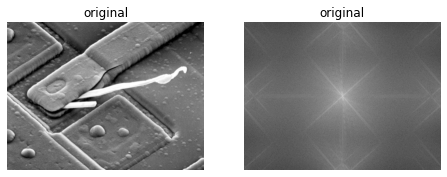

In [47]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0429(a)(blown_ic).tif")
ax = fig.add_subplot(2,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

image_fft = np.fft.fft2(image)
image_fft_shift = np.fft.fftshift(image_fft)
res = np.log(1+np.abs(image_fft_shift))

ax = fig.add_subplot(2,3,2)
ax.imshow(res ,cmap = 'gray')
ax.axis('off')
ax.set_title(f"original")

## 使用直流项为0的滤波器传递函数对于图像进行滤波

In [57]:
def image_scaling(image,k):
    new_image = np.zeros((image.shape[0],image.shape[1]))
    new_image=k*(image - np.min(image))/(np.max(image) - np.min(image))
    return new_image

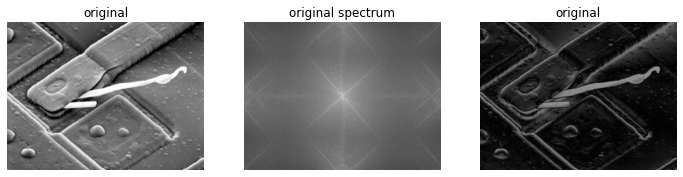

In [70]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0429(a)(blown_ic).tif")
ax = fig.add_subplot(2,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

# 进行傅里叶变换
image_fft = np.fft.fft2(image)
image_fft_shift = np.fft.fftshift(image_fft)
res = np.log(1+np.abs(image_fft_shift))
res = image_scaling(res,255)

ax = fig.add_subplot(2,3,2)
ax.imshow(res ,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original spectrum")

# 进行滤波
image_fft_shift[int(image.shape[0]/2) , int(image.shape[1]/2)] = 0
image_ifft_shift = np.fft.ifftshift(image_fft_shift)
# 进行傅里叶反变换
image_ifft = np.abs(np.fft.ifft2(image_ifft_shift))

ax = fig.add_subplot(2,3,3)
ax.imshow(image_ifft ,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

plt.show()

# 4.8 使用低通频率域滤波器平滑图像

In [114]:
def get_LPF_H(d,image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    distance = np.sqrt(np.power((i - image.shape[1]//2),2) + np.power((j - image.shape[0]//2),2))
    mask = distance.copy()
    mask[distance > d] = 0
    mask[distance <= d] = 1
    return mask

def LPF(d,image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image_pad)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = get_LPF_H(d,image_pad)
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real
    
def pad_image_mirro(image):
    image_filled = np.zeros((2*image.shape[0],2*image.shape[1]))
    image_filled[0:image.shape[0],0:image.shape[1]] = image
    image_filled[image.shape[0]:2*image.shape[0],0:image.shape[1]] = image
    image_filled[0:image.shape[0],image.shape[1]:2*image.shape[1]] = image
    image_filled[image.shape[0]:2*image.shape[0],image.shape[1]:2*image.shape[1]] = image
    return image_filled

def pad_image_zero(image):
    image_filled = np.zeros((2*image.shape[0],2*image.shape[1]))
    image_filled[0:image.shape[0],0:image.shape[1]] = image
    return image_filled

def image_centralized(image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    mask = np.power(-1,i+j)
    new_image = image * mask
    return new_image

# 功率计算好像有点问题
def get_p_sum(image):
    image_fft = np.fft.fft2(image)
    image_fft_shift = np.fft.fftshift(image_fft)
    powersum = np.sum(np.power(np.abs(image_fft_shift),2))
    return powersum

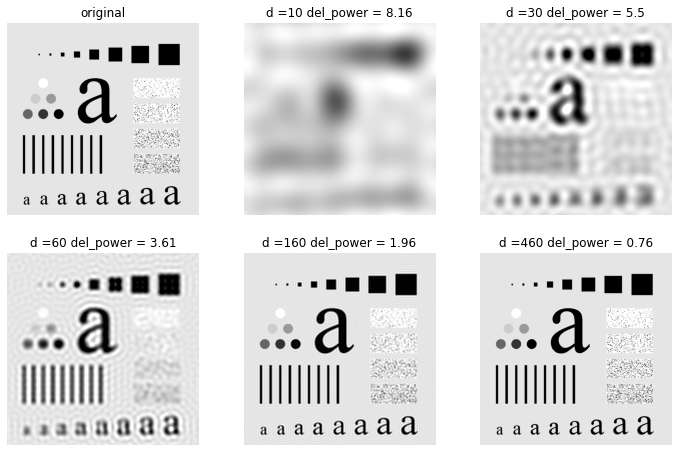

In [45]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0441(a)(characters_test_pattern).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

ds = [10,30,60,160,460]

for i in range(len(ds)):
    new_image = LPF(ds[i],image)
    ax = fig.add_subplot(3,3,i+2)
    ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
    ax.axis('off')
    power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
    ax.set_title(f"d ={ds[i]} del_power = {power_del}")

## 4.8.2 高斯低通滤波器

In [115]:
def get_GLPF_H(d,image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    distance = np.power((i - image.shape[1]//2),2) + np.power((j - image.shape[0]//2),2)
    mask = np.exp(-distance/(2*d*d))
    return mask

def GLPF(d,image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image_pad)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = get_GLPF_H(d,image_pad)
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real
    
def pad_image_mirro(image):
    image_filled = np.zeros((2*image.shape[0],2*image.shape[1]))
    image_filled[0:image.shape[0],0:image.shape[1]] = image
    image_filled[image.shape[0]:2*image.shape[0],0:image.shape[1]] = image
    image_filled[0:image.shape[0],image.shape[1]:2*image.shape[1]] = image
    image_filled[image.shape[0]:2*image.shape[0],image.shape[1]:2*image.shape[1]] = image
    return image_filled

def pad_image_zero(image):
    image_filled = np.zeros((2*image.shape[0],2*image.shape[1]))
    image_filled[0:image.shape[0],0:image.shape[1]] = image
    return image_filled

def image_centralized(image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    mask = np.power(-1,i+j)
    new_image = image * mask
    return new_image

# 功率计算好像有点问题
def get_p_sum(image):
    image_fft = np.fft.fft2(image)
    image_fft_shift = np.fft.fftshift(image_fft)
    powersum = np.sum(np.power(np.abs(image_fft_shift),2))
    return powersum

In [79]:
d = 120
i = np.arange(image.shape[1])
j = np.arange(image.shape[0])
i,j = np.meshgrid(i,j)
distance = np.power((i - image.shape[0]//2),2) + np.power((j - image.shape[0]//2),2)
mask = np.exp(-distance/(2*d*d))



array([], shape=(1, 0), dtype=int64)

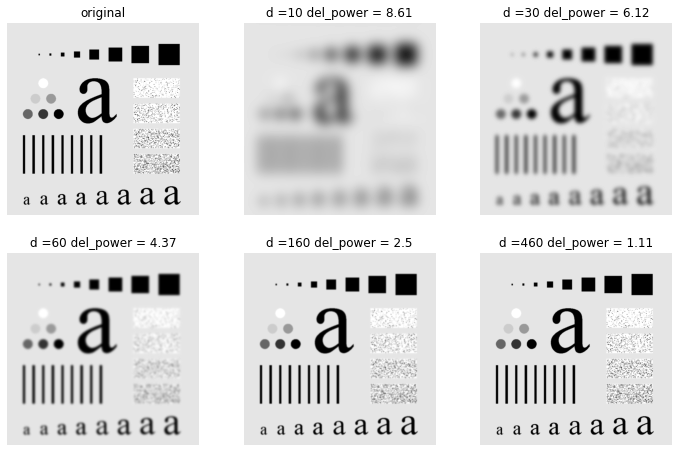

In [47]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0441(a)(characters_test_pattern).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

ds = [10,30,60,160,460]

for i in range(len(ds)):
    new_image = GLPF(ds[i],image)
    ax = fig.add_subplot(3,3,i+2)
    ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
    ax.axis('off')
    power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
    ax.set_title(f"d ={ds[i]} del_power = {power_del}")

## 4.8.3 巴特沃斯低通滤波器

In [116]:
def get_BLPF_H(d,n,image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    distance = np.sqrt(np.power((i - image.shape[1]//2),2) + np.power((j - image.shape[0]//2),2))
    mask = 1/(1+np.power(distance/d,2*n))
    return mask

def BLPF(d,n,image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image_pad)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = get_BLPF_H(d,n,image_pad)
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real
    
def pad_image_mirro(image):
    image_filled = np.zeros((2*image.shape[0],2*image.shape[1]))
    image_filled[0:image.shape[0],0:image.shape[1]] = image
    image_filled[image.shape[0]:2*image.shape[0],0:image.shape[1]] = image
    image_filled[0:image.shape[0],image.shape[1]:2*image.shape[1]] = image
    image_filled[image.shape[0]:2*image.shape[0],image.shape[1]:2*image.shape[1]] = image
    return image_filled

def pad_image_zero(image):
    image_filled = np.zeros((2*image.shape[0],2*image.shape[1]))
    image_filled[0:image.shape[0],0:image.shape[1]] = image
    return image_filled

def image_centralized(image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    mask = np.power(-1,i+j)
    new_image = image * mask
    return new_image

# 功率计算好像有点问题
def get_p_sum(image):
    image_fft = np.fft.fft2(image)
    image_fft_shift = np.fft.fftshift(image_fft)
    powersum = np.sum(np.power(np.abs(image_fft_shift),2))
    return powersum

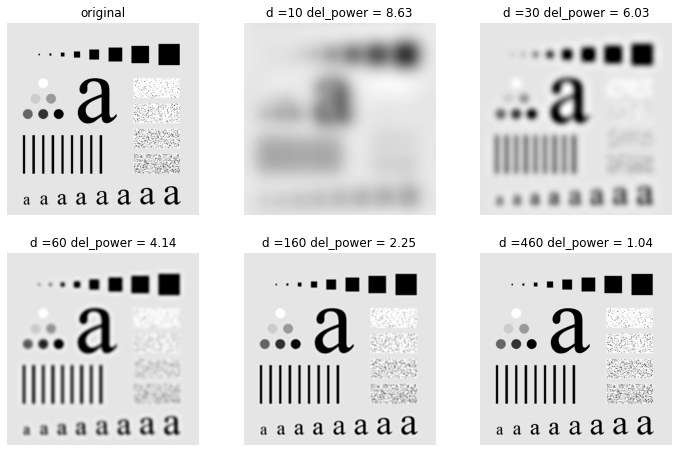

In [49]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0441(a)(characters_test_pattern).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

ds = [10,30,60,160,460]

for i in range(len(ds)):
    new_image = BLPF(ds[i],2.25,image)
    ax = fig.add_subplot(3,3,i+2)
    ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
    ax.axis('off')
    power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
    ax.set_title(f"d ={ds[i]} del_power = {power_del}")

## 4.8.4 低通滤波的其他例子

Text(0.5, 1.0, 'd =120 del_power = 4.77')

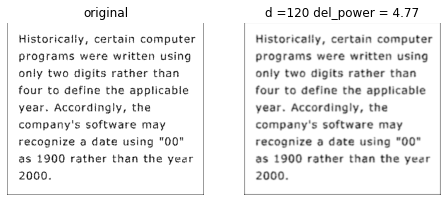

In [117]:
# 字符识别 中对字符进行修复
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0419(a)(text_gaps_of_1_and_2_pixels).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

new_image = GLPF(120,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
new_image = image_scaling(new_image,255)
ax = fig.add_subplot(3,3,2)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

Text(0.5, 1.0, 'd =120 del_power = 1.49')

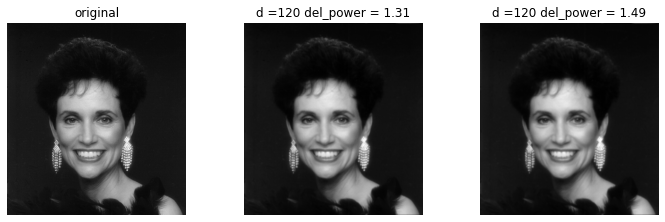

In [118]:
# 印刷业中去除皱纹
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0450(a)(woman_original).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

new_image = GLPF(150,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
new_image = image_scaling(new_image,255)
ax = fig.add_subplot(3,3,2)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

new_image = GLPF(130,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
new_image = image_scaling(new_image,255)
ax = fig.add_subplot(3,3,3)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

Text(0.5, 1.0, 'd =120 del_power = 6.06')

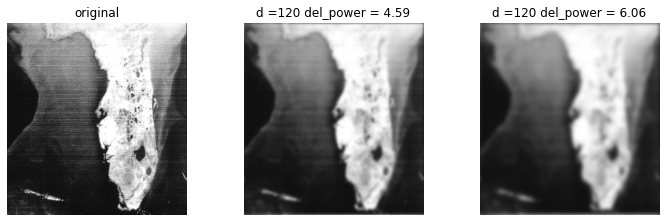

In [120]:

import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0451(a)(satellite_original).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

new_image = GLPF(50,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,2)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

new_image = GLPF(30,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,3)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

# 4.9 使用高通滤波器锐化图像

In [121]:
def get_HPF_H(d,image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    distance = np.sqrt(np.power((i - image.shape[1]//2),2) + np.power((j - image.shape[0]//2),2))
    mask = distance.copy()
    mask[distance > d] = 1
    mask[distance <= d] = 0
    return mask

def HPF(d,image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image_pad)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = get_HPF_H(d,image_pad)
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real

def get_GHPF_H(d,image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    distance = np.power((i - image.shape[1]//2),2) + np.power((j - image.shape[0]//2),2)
    mask = 1 - np.exp(-distance/(2*d*d))
    return mask

def GHPF(d,image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image_pad)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = get_GHPF_H(d,image_pad)
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real

def get_BHPF_H(d,n,image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    distance = np.sqrt(np.power((i - image.shape[1]//2),2) + np.power((j - image.shape[0]//2),2))
    mask = 1- (1/(1+np.power(distance/d,2*n)))
    return mask

def BHPF(d,n,image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image_pad)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = get_BHPF_H(d,n,image_pad)
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real

def pad_image_mirro(image):
    image_filled = np.zeros((2*image.shape[0],2*image.shape[1]))
    image_filled[0:image.shape[0],0:image.shape[1]] = image
    image_filled[image.shape[0]:2*image.shape[0],0:image.shape[1]] = image
    image_filled[0:image.shape[0],image.shape[1]:2*image.shape[1]] = image
    image_filled[image.shape[0]:2*image.shape[0],image.shape[1]:2*image.shape[1]] = image
    return image_filled

def pad_image_zero(image):
    image_filled = np.zeros((2*image.shape[0],2*image.shape[1]))
    image_filled[0:image.shape[0],0:image.shape[1]] = image
    return image_filled

def image_centralized(image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    mask = np.power(-1,i+j)
    new_image = image * mask
    return new_image

# 功率计算好像有点问题
def get_p_sum(image):
    image_fft = np.fft.fft2(image)
    image_fft_shift = np.fft.fftshift(image_fft)
    powersum = np.sum(np.power(np.abs(image_fft_shift),2))
    return powersum

Text(0.5, 1.0, 'd =120 del_power = 97.93')

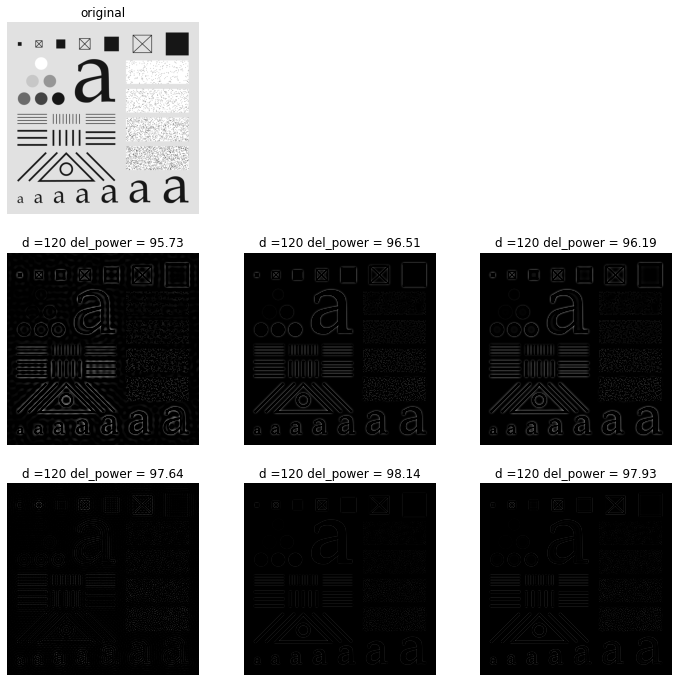

In [111]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/testpattern1024.tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

new_image = HPF(60,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,4)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

new_image = GHPF(60,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,5)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

new_image = BHPF(60,2,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,6)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

new_image = HPF(160,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,7)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

new_image = GHPF(160,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,8)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

new_image = BHPF(160,2,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,9)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

Text(0.5, 1.0, 'd =120 del_power = 97.93')

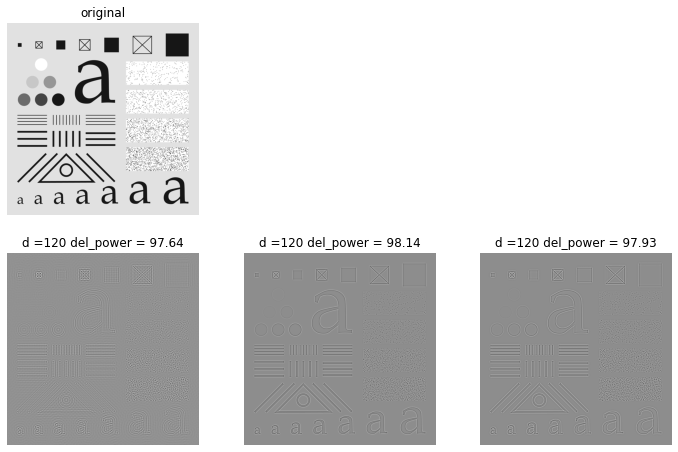

In [112]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/testpattern1024.tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

new_image = HPF(160,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,4)
ax.imshow(new_image,cmap = 'gray')
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

new_image = GHPF(160,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,5)
ax.imshow(new_image,cmap = 'gray')
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

new_image = BHPF(160,2,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,6)
ax.imshow(new_image,cmap = 'gray')
ax.axis('off')
ax.set_title(f"d ={120} del_power = {power_del}")

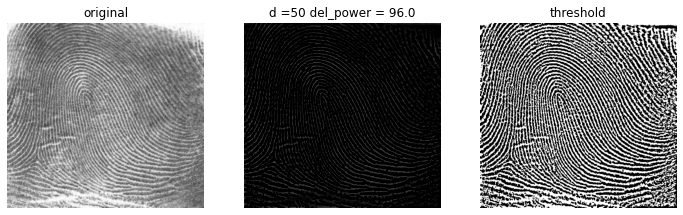

In [128]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0457(a)(thumb_print).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

new_image = BHPF(50,4,image)
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,2)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={50} del_power = {power_del}")

new_image[new_image > 0] = 255
new_image[new_image <= 0] = 0
ax = fig.add_subplot(3,3,3)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"threshold")

plt.show()

## 4.9.2 频率域中的拉普拉斯变换

In [136]:
def get_Laplace_H(image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    distance = np.power((i - image.shape[1]//2),2) + np.power((j - image.shape[0]//2),2)
    mask = -4*np.power(np.pi,2)*distance
    return mask

def Laplace(image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image_pad)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = get_Laplace_H(image_pad)
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real

Text(0.5, 1.0, 'd =50 del_power = -10.18')

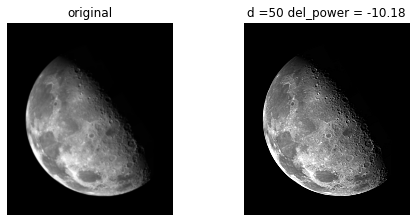

In [171]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0458(a)(blurry_moon).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

new_image = Laplace(image)
# 对拉式变换后的数据进行归一化处理
new_image_la = 255*new_image/np.max(np.abs(new_image))
new_image = image - new_image_la
power_del = round((1 - get_p_sum(pad_image_zero(new_image))/get_p_sum(pad_image_zero(image)))*100,2)
ax = fig.add_subplot(3,3,2)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"d ={50} del_power = {power_del}")



## 4.9.3 钝化掩蔽、高提升滤波和高频强调滤波

In [185]:
def get_GHFH_H(k1,k2,d,image): # HFH  = HIGH FREQUENCY HIGHLIGHT
    mask = get_GHPF_H(d,image)
    mask = k1 + k2*mask
    return mask

def GHFH(k1,k2,d,image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image_pad)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = get_GHFH_H(k1,k2,d,image_pad)
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real

def HistogramEqualization(image):
    # 统计直方图中的数据
    hist,bins = np.histogram(image.reshape(-1),bins = 256,range = (0,256))
    #构建查找表
    
    lut = np.zeros(256)
    hist_cum = hist.cumsum()
    lut_temp = np.ma.array(hist_cum,mask = (hist_cum == 0))
    lut_temp = 255 * (lut_temp - np.min(lut_temp))/(np.max(lut_temp)-np.min(lut_temp))
    lut = np.ma.filled(lut_temp,0).astype("uint8")
    # 根据查找表对新图像进行赋值
    new_image = np.zeros((image.shape[0],image.shape[1]))
    for i in range(0,image.shape[0]):
        for j in range (0,image.shape[1]):
            new_image[i,j] = lut[image[i,j]]
    return new_image

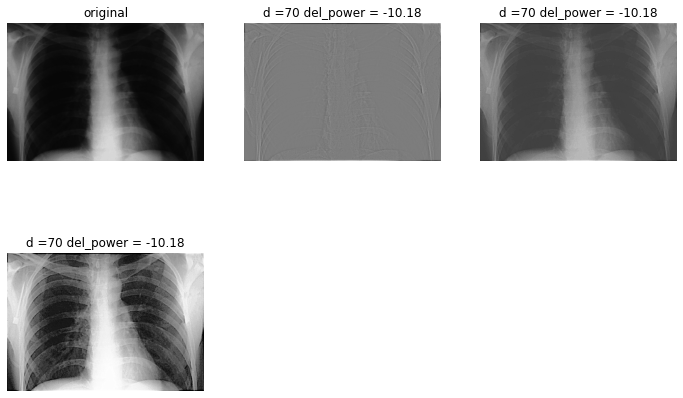

In [195]:

import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0459(a)(orig_chest_xray).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

new_image = GHPF(70,image)
ax = fig.add_subplot(3,3,2)
ax.imshow(new_image,cmap = 'gray')
ax.axis('off')
ax.set_title(f"d ={70} del_power = {power_del}")

new_image1 = GHFH(0.5,0.75,70,image)
ax = fig.add_subplot(3,3,3)
ax.imshow(new_image1,cmap = 'gray')
ax.axis('off')
ax.set_title(f"d ={70} del_power = {power_del}")

new_image = HistogramEqualization(image_scaling(new_image1,255).astype('uint8'))
ax = fig.add_subplot(3,3,4)
ax.imshow(new_image,cmap = 'gray')
ax.axis('off')
ax.set_title(f"d ={70} del_power = {power_del}")

plt.show()

## 4.9.4 同态滤波

In [196]:
def get_HomomorphicFilter_H(rh,rl,c,d,image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    distance = np.power((i - image.shape[1]//2),2) + np.power((j - image.shape[0]//2),2)
    mask = (rh-rl)*(1 - np.exp(-c*distance/(d*d)))+rl
    return mask

def HomomorphicFilter(rh,rl,c,d,image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image_pad)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = get_HomomorphicFilter_H(rh,rl,c,d,image_pad)
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real

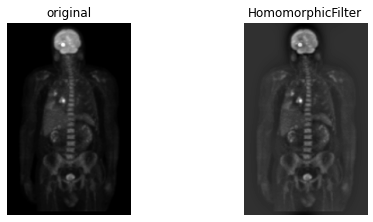

In [198]:

import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0462(a)(PET_image).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

new_image = HomomorphicFilter(3,0.4,5,20,image)
ax = fig.add_subplot(3,3,2)
ax.imshow(new_image,cmap = 'gray')
ax.axis('off')
ax.set_title(f"HomomorphicFilter")

plt.show()


# 4.10 选择性滤波

## 4.10.1 带阻滤波器和带通滤波器

In [424]:
def get_IBRF_H(w,c,image):
    c_low = c - w/2
    c_high = c + w/2
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    distance = np.sqrt(np.power((i - image.shape[1]//2),2) + np.power((j - image.shape[0]//2),2))
    mask = distance.copy()
    mask[distance < c_low] = 1
    mask[distance > c_high] = 1
    mask[np.logical_and(distance >= c_low,distance <= c_high)] = 0
    return mask

def IBRF(w,c,image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image_pad)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = get_IBRF_H(w,c,image_pad)
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real

def get_GBRF_H(w,c,image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    distance = np.power((i - image.shape[1]//2),2) + np.power((j - image.shape[0]//2),2)
    mask = 1 - np.exp(-np.power((np.power(distance,2) - np.power(c,2))/((distance+1e-8) * w),2))
    return mask

def GBRF(w,c,image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image_pad)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = get_GBRF_H(w,c,image_pad)
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real

def get_BBRF_H(w,c,n,image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    distance = np.sqrt(np.power((i - image.shape[1]//2),2) + np.power((j - image.shape[0]//2),2))
    mask =  1/(1+np.power(distance*w/(np.power(distance,2)-np.power(c,2)+1e-8),2*n))
    return mask

def BBRF(w,c,n,image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image_pad)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = get_BBRF_H(w,c,n,image_pad)
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real


Text(0.5, 1.0, 'BBRF')

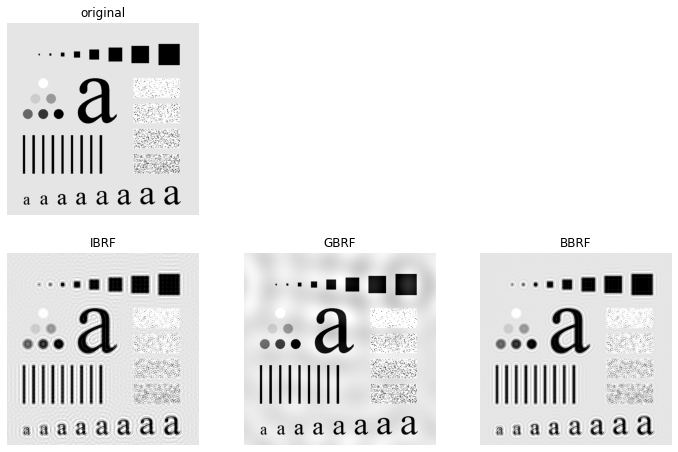

In [425]:
# 运行会由于被除数为0而出现警告
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0441(a)(characters_test_pattern).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

new_image = IBRF(60,128,image)
ax = fig.add_subplot(3,3,4)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"IBRF")

new_image = GBRF(60,128,image)
ax = fig.add_subplot(3,3,5)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"GBRF")

new_image = BBRF(60,128,2,image)
ax = fig.add_subplot(3,3,6)
ax.imshow(new_image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"BBRF")

## 4.10.2 陷波滤波器 (此部分 并没有进行函数模块化处理)

In [532]:
def get_BNPF_H(uk,vk,d0,n,image):
    i = np.arange(image.shape[1])
    j = np.arange(image.shape[0])
    i,j = np.meshgrid(i,j)
    dk_p = np.sqrt(np.power((i - image.shape[1]//2 - uk),2) + np.power((j - image.shape[0]//2 - vk),2))
    dk_n = np.sqrt(np.power((i - image.shape[1]//2 + uk),2) + np.power((j - image.shape[0]//2 + vk),2))
    mask = (1/(1+np.power(d0/(dk_p+1e-8),n))) * (1/(1+np.power(d0/(dk_n+1e-8),n)))
    return mask

# 该陷波滤波器只对未进行扩展的图像进行了处理（因为获取陷波滤波器的中心太难找了 ~ 。~）
def BNPF(uk,vk,dk,n,num,image):
    # 进行镜像填充
    image_pad = pad_image_mirro(image)
    # 中心化
    image_pad_cen = image_centralized(image)
    # 傅里叶变换
    image_fft = np.fft.fft2(image_pad_cen)
    # 获取低通滤波器 并进行滤波
    mask = np.ones((image.shape[0],image.shape[1]))
    for i in range(num):
        temp = get_BNPF_H(uk[i],vk[i],dk,n,image)
        mask = mask * temp
    image_lpf = image_fft * mask
    # 进行反变换
    image_ifft = np.fft.ifft2(image_lpf)
    # 去中心化
    image_ifft_uncen = image_centralized(image_ifft)
    # 获取图像
    image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]
    return image_ifft_uncen.real

Text(0.5, 1.0, 'original')

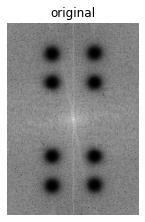

In [533]:
# 用于调整来确定中心位置

import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

mask0 = get_BNPF_H(-27,47,10,4,image)
mask1 = get_BNPF_H(-27,85,10,4,image)
mask2 = get_BNPF_H(27,47,10,4,image)
mask3 = get_BNPF_H(27,84,10,4,image)
mask = mask0 * mask1 * mask2 * mask3

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0464(a)(car_75DPI_Moire).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(res * mask,cmap = 'gray')
ax.axis('off')
ax.set_title(f"original")

Text(0.5, 1.0, 'original')

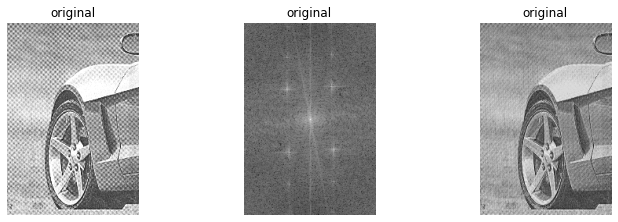

In [536]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0464(a)(car_75DPI_Moire).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

fft_specturm = np.fft.fft2(image_centralized(image))
res = np.log(1 + np.abs(fft_specturm))
ax = fig.add_subplot(3,3,2)
ax.imshow(res ,cmap = 'gray')
ax.axis('off')
ax.set_title(f"original")


uk = [-27,-27,27,27]
vk = [47,85,47,84]
num = 4
dk = 10
n = 5
new_image = BNPF(uk,vk,dk,n,num,image)

ax = fig.add_subplot(3,3,3)
ax.imshow(image_ifft_uncen.real ,cmap = 'gray')
ax.axis('off')
ax.set_title(f"original")

Text(0.5, 1.0, 'original')

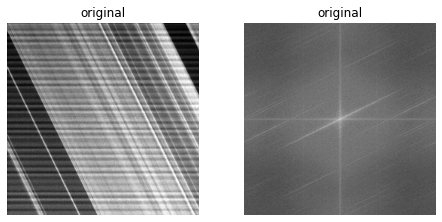

In [542]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0465(a)(cassini).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")

fft_specturm = np.fft.fft2(image_centralized(image))
res = np.log(1 + np.abs(fft_specturm))
ax = fig.add_subplot(3,3,2)
ax.imshow(res ,cmap = 'gray')
ax.axis('off')
ax.set_title(f"original")

Text(0.5, 1.0, 'image after filter')

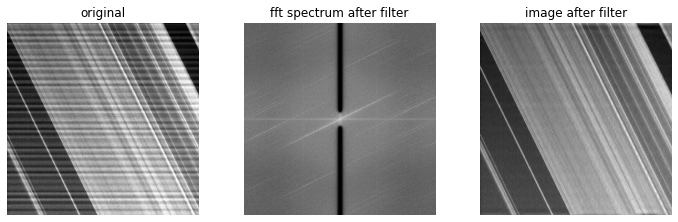

In [564]:
# 生成条形的mask
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

mask = np.ones((image.shape[0],image.shape[1]))
i = 0
while i < image.shape[0]:
    temp = get_BNPF_H(0,30+i,6,4,image)
    mask = mask * temp
    i = i + 3

fig = plt.figure(figsize=(12,12))
image = tiff.imread("G:/Python/图像数字处理/第四章 频率域滤波/DIP3E_Original_Images_CH04/Fig0465(a)(cassini).tif")
ax = fig.add_subplot(3,3,1)
ax.imshow(image,cmap = 'gray',vmin=0,vmax=255)
ax.axis('off')
ax.set_title(f"original")


ax = fig.add_subplot(3,3,2)
ax.imshow(res * mask,cmap = 'gray')
ax.axis('off')
ax.set_title(f"fft spectrum after filter")

image_pad_cen = image_centralized(image)
# 傅里叶变换
image_fft = np.fft.fft2(image_pad_cen)
# 获取低通滤波器 并进行滤波
image_lpf = image_fft * mask
# 进行反变换
image_ifft = np.fft.ifft2(image_lpf)
# 去中心化
image_ifft_uncen = image_centralized(image_ifft)
# 获取图像
image_ifft_uncen = image_ifft_uncen[0:image.shape[0],0:image.shape[1]]

ax = fig.add_subplot(3,3,3)
ax.imshow(image_ifft_uncen.real,cmap = 'gray')
ax.axis('off')
ax.set_title(f"image after filter")
